In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install transformers
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("emotion")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(dataset["train"].features["label"].names))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = dataset["train"].map(preprocess_function, batched=True)
eval_dataset = dataset["validation"].map(preprocess_function, batched=True)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use GPU 0

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,      # training dataset
    eval_dataset=eval_dataset, # evaluation dataset
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
10,1.657300
20,1.547500
30,1.611300
40,1.554500
50,1.569600
60,1.470300
70,1.604900
80,1.554700
90,1.504900
100,1.523900


TrainOutput(global_step=3000, training_loss=0.27974796571334204, metrics={'train_runtime': 4378.3007, 'train_samples_per_second': 10.963, 'train_steps_per_second': 0.685, 'total_flos': 1.2629784231936e+16, 'train_loss': 0.27974796571334204, 'epoch': 3.0})

In [ ]:
model.save_pretrained("/content/drive/My Drive/Colab Notebooks/NLP - Keerthana mam/Models/")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

config = AutoConfig.from_pretrained('config.json')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("pytorch_model.bin", config=config)

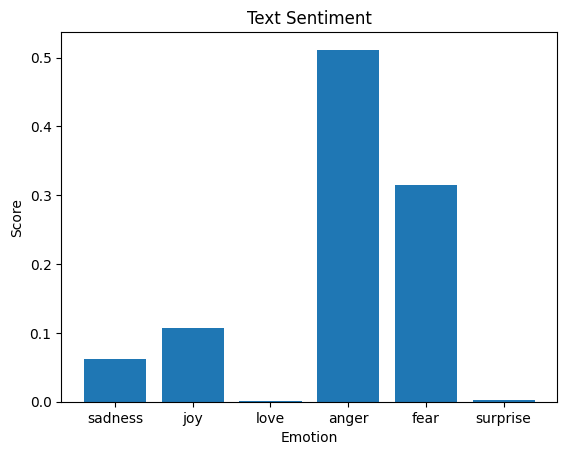

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def preprocess_sentence(sentence):
    return tokenizer(sentence, padding="max_length", truncation=True, return_tensors="pt")

input_sentence = "i had ordered an optimus prime and it turned out to be broken"
preprocessed_input = preprocess_sentence(input_sentence)

with torch.no_grad():
    logits = model(**preprocessed_input)[0]
    probs = F.softmax(logits, dim=1)

probs = np.array(probs).tolist()
emotions = dataset["train"].features["label"].names

probs_label = {emotions[i] : probs[0][i] for i in range(len(probs[0]))}



x = list(probs_label.keys())
y = list(probs_label.values())

plt.bar(x, y)
plt.title('Text Sentiment')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.show()




In [ ]:
print(dataset["train"].features["label"].names)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [5]:
import speech_recognition as sr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.figure import Figure


config = AutoConfig.from_pretrained('Models/config.json')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("Models/pytorch_model.bin", config=config)


Say something!
I am so mad at you


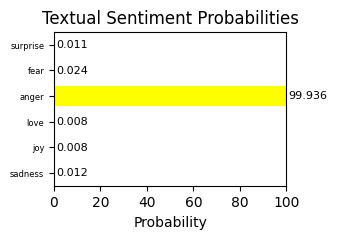

In [22]:
# initialize the recognizer
r = sr.Recognizer()
flag = False


# open the microphone and start recording
with sr.Microphone() as source:
    print("Say something!")
    audio = r.listen(source)





try:
    text = r.recognize_google(audio)
    flag = True
    print(text)
except sr.UnkownValueError:
    print('No speech detected, try again')


if flag == True:
    def preprocess_sentence(sentence):
        return tokenizer(sentence, padding="max_length", truncation=True, return_tensors="pt")

    # perform classification on the transcribed text
    input_sentence = text
    preprocessed_input = preprocess_sentence(input_sentence)

    with torch.no_grad():
        logits = model(**preprocessed_input)[0]
        probs = F.softmax(logits, dim=1)

    probs = np.array(probs).tolist()


    text_fig = plt.figure(figsize=(3, 2), dpi=100)
    text_ax = text_fig.add_subplot(111)

    text_prediction = np.array(probs)[0].tolist()
    text_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

    emotion_probs = [prob*100 for prob in text_prediction]

    # Set bar color based on emotion
    colors = ['#FF5733', '#6A5ACD', '#800000', '#FFFF00', '#A9A9A9', '#1E90FF']


    # Create horizontal bar chart

    y_pos = np.arange(len(text_emotions))
    text_ax.barh(y_pos, emotion_probs, align='center', color=colors)
    text_ax.set_yticks(y_pos)
    text_ax.set_yticklabels(text_emotions, fontsize=6)
    text_ax.invert_yaxis()  # labels read top-to-bottom
    text_ax.set_xlabel('Probability')
    text_ax.set_title('Textual Sentiment Probabilities')


    # Add probability values as labels above each bar
    for i, prob in enumerate(emotion_probs):
        text_ax.text(prob+1, i, str(round(prob, 3)), color='black', va='center', fontsize=8)

    # Set the minimum and maximum limits of the x-axis
    text_ax.set_xlim(0, 100)
    text_ax.set_ylim(-0.5, len(text_emotions) - 0.5)

    plt.show()



In [11]:
probs = probs[0]
print(probs)

[0.04108966514468193, 0.010654332116246223, 0.0015741471434012055, 0.7227158546447754, 0.2171189934015274, 0.00684698112308979]
